# Machine Learning Engineer@ Epic Software Systems 
Today you are Machine Learning Engineer@ Epic Software Systems, and your task is to develop a new Recommendation System for the Opthalmologists (eye doctors)!

Diabetic Retinopathy (DR) is a pathology that impacts patients with Diabetes Mellitus 2, such that vision is compromised. Base paper on Automated classification of diabetic retinopathy:
https://ieeexplore.ieee.org/abstract/document/6680633

Diabetic Retinopathy classification using modified AlexNet paper: https://www.sciencedirect.com/science/article/abs/pii/S0045790618334190

Paper available at https://drive.google.com/file/d/1nl5tYA2jJ1Up_malA8uQmvwHu6UH0k-r/view?usp=sharing


Automated classification of DR severity can help streamlie the treatment process such that patients with higher severity are seen by the doctor first followed by the less severe patiets. This problem of DR clasification is significant since retinal images are biometrics (unique for each individual) which makes generalized modeling difficult and since 90% of the diabetic population that get imaged each year are have NO DR.

Thus, the primary task is to automatically screen the patients that have NO DR (y=0), vs ones with mild DR (y=1), moderate DR (y=2) and severe DR (y=4). In this assignment you will develop such an automated system such that separates the normal images (y=0) from the non-zero ones (y=1,2,3)

### Load TensorBoard and related libraries

In [3]:
%load_ext tensorboard
from tensorflow import keras
import os
pwd = os.getcwd()
print(pwd)

/home/leon/repos/Canvas


In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
#Load the libraries
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

In [6]:
import seaborn as sns
import pandas as pd

### Task 0: Get familiar with the data

Number of images = 1194
This image has DR = [3]
Maximum pixel value in image = 223


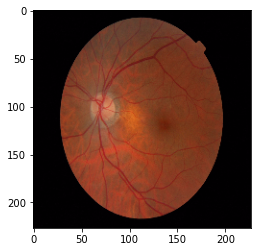

In [7]:
#Read the data and split into train and validation
from sklearn.model_selection import train_test_split
import h5py
f = h5py.File('data/1194_DR_smallimages.h5', 'r')
images = f['images']
labels = np.array(f['meta'])
print(f'Number of images = {len(labels)}')
#Plot the image and its label
num = 100
plt.imshow(images[num])
print(f"This image has DR = {labels[num]}")
print(f"Maximum pixel value in image = {np.max(images[num])}")

### Task 1: Data Pre-processing: 
1. Exploratory data analysis (Frequency of labels)
2. Normalization of images in [0, 1] range.
3. Generation of Training, Test data sets (66/33% split)

### Exercise: 
Plot a histogram illustrating the number of images corresponding to each DR severity label

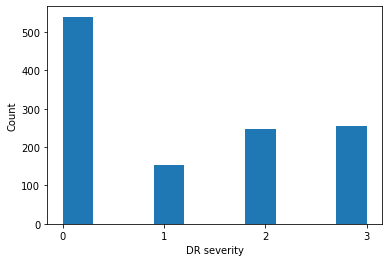

In [8]:
class_labels = [0, 1, 2, 3]
plt.hist(labels);
plt.xticks(ticks = class_labels, labels=class_labels);
plt.xlabel("DR severity");
plt.ylabel("Count");

In [9]:
label_df = pd.DataFrame(labels, columns=['label'])

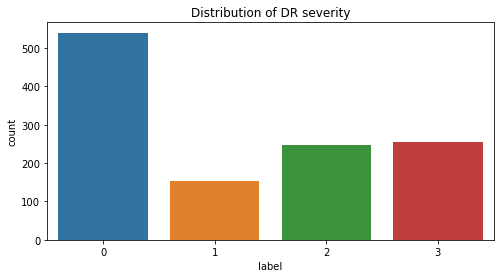

In [10]:
plt.figure(figsize=(8,4));
sns.countplot(x='label', data=label_df);
plt.title("Distribution of DR severity");

### Exercise: 
Normalize the images' pixel values so they fall in the range [0, 1]

Maximum pixel value in an image = 1.0


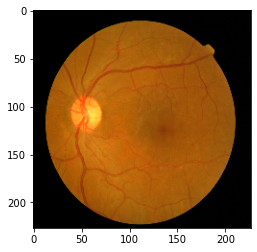

In [12]:
images_new = images / np.max(images)
plt.imshow(images_new[10])
print(f"Maximum pixel value in an image = {np.max(images_new[10])}")

### Exercise: 
Binarize the class labels. 
Set up 2 one-hot-encoded columns. Column 0 will contain a 1 for every row where the label is 0. Column 1 will contain a 1 for every row where the label is 1, 2, or 3.

You might be wondering why we don't use a single one-hot-encoded column, since our problem is binary classification. This will become clear in Task 2, when we inspect the AlexNet architecture. 


In [13]:
# Initialize the one-hot-encoded array of labels as 2 columns of zeros
one_hot_labels = np.zeros([labels.shape[0], 2])
# Find the rows where the label is 0
lab0 = np.where(labels == 0)[0]
# Find the rows where the label is 1, 2, or 3
lab1 = np.where((labels == 1) | (labels == 2) | (labels == 3))[0] #no.where
# Set column 0 to 1 in the rows where the label is 0
one_hot_labels[lab0, 0] = 1
# Set column 1 to 1 in the rows where the label is 1, 2, or 3
one_hot_labels[lab1, 1] = 1

### Exercise: 
Perform a 2/3 - 1/3 train-test split on the data

X_train.shape = (796, 227, 227, 3)
X_test.shape  = (398, 227, 227, 3)


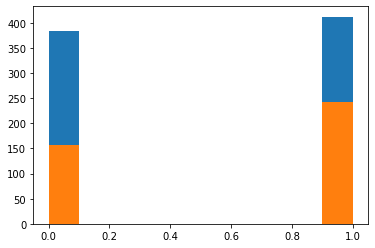

In [14]:
def split_data(mat, target, train_ratio):
    from sklearn.utils import shuffle

    permuted_X, permuted_y = shuffle([mat, target], random_state=45)#shuffle([mat, target], random_state=45)
    # Get the number of rows in the training data
    train_rows = int(np.floor(train_ratio * target.shape[0]))
    # Place the first `train_rows` shuffled rows into the training data 
    # and the remaining rows into the test data
    X_train = permuted_X[0:train_rows,:, :]
    X_test  = permuted_X[train_rows:,:, :]
    Y_train = permuted_y[0:train_rows]
    Y_test  = permuted_y[train_rows:]
    return X_train, X_test, Y_train, Y_test

# Call the function you just defined to create the training and test data
X_train, X_test, Y_train, Y_test = split_data(images_new, one_hot_labels, 2/3)

# Visualize the distribution of the binarized labels for both the training and test data
plt.hist(Y_train[:,1])
plt.hist(Y_test[:,1])
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')

### Task 2: Model Definition, classification and prediction (No regularization)

#### AlexNet architecture

In [16]:
# Define the AlexNet model [This is given]
#1. Model Definition
class AlexNet(Sequential):
   def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    

    self.add(Flatten())
    
    self.add(Dense(num_classes, activation= 'softmax'))

    self.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Since our problem involves binary classification, set `num_classes` to 2

In [17]:
num_classes = 2

### Exercise: 
Instantiate the model and summarize its architecture

In [18]:
model = AlexNet(input_shape=X_train.shape[1:], num_classes=num_classes)
model.summary() 

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885

### Exercise: 
Train the model. 

If you want to use TensorBoard to visualize how its properties evolve over the training epochs, you'll have to create a log directory and employ a TensorBoard callback. If you'd like, you can implement them in v1 of this notebook, but it's not required. v2 will include them, however.

In training the model, set aside 20% of the data as a validation set. Use a batch size of 100. Set the output verbosity to 1. Train the model for 40 epochs.

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from helper_functions import *
# Specify location of helper functions
#model.compile()
training_history = model.fit(X_train, Y_train, batch_size=100, epochs=40, verbose=1, validation_split=0.2)


print("Average test loss: ", np.average(training_history.history['loss']))

Epoch 1/40
7/7 [==============================] - 5s 130ms/step - loss: 35.7557 - accuracy: 0.4860 - val_loss: 1194522.6250 - val_accuracy: 0.3250
Epoch 2/40
7/7 [==============================] - 1s 74ms/step - loss: 7.1347 - accuracy: 0.5194 - val_loss: 9323373.0000 - val_accuracy: 0.3000
Epoch 3/40
7/7 [==============================] - 1s 77ms/step - loss: 6.6967 - accuracy: 0.5004 - val_loss: 5536299.0000 - val_accuracy: 0.3000
Epoch 4/40
7/7 [==============================] - 1s 78ms/step - loss: 4.5026 - accuracy: 0.5199 - val_loss: 189185.5000 - val_accuracy: 0.5562
Epoch 5/40
7/7 [==============================] - 1s 76ms/step - loss: 5.1154 - accuracy: 0.5530 - val_loss: 5236912.0000 - val_accuracy: 0.3000
Epoch 6/40
7/7 [==============================] - 1s 77ms/step - loss: 3.3537 - accuracy: 0.5575 - val_loss: 250617.8281 - val_accuracy: 0.6938
Epoch 7/40
7/7 [==============================] - 1s 77ms/step - loss: 2.1342 - accuracy: 0.6219 - val_loss: 742769.1250 - val_acc

### Exercise: 
Display loss and accuracy for both the training and validation data. 

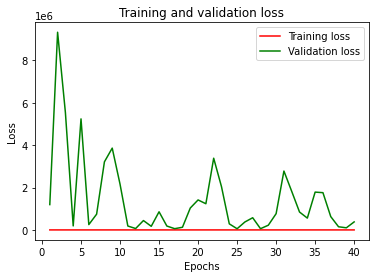

In [20]:
print_loss_history(training_history)

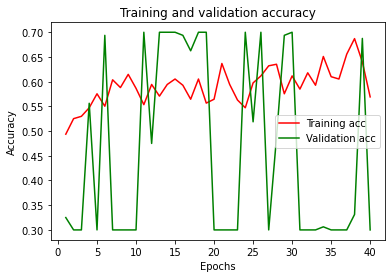

In [21]:
print_accuracy_history(training_history)

### Exercise: 
Generate predictions with the test data

In [22]:
prediction_values = np.argmax(model.predict(X_test), axis=-1)

In [ ]:
prediction_values2 = model.predict_classes(X_test)

### Exercise: 
Evaluate the predictions against the Number 1 column of `Y_test`

In [25]:
# Import the necessary functions from sklearn.metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
print(f'Accuracy = {accuracy_score(Y_test[:,1], prediction_values)}')
print(f'F1 = {f1_score(Y_test[:,1], prediction_values)}')
print(f'Precision = {precision_score(Y_test[:,1], prediction_values)}')
print(f'Recall = {recall_score(Y_test[:,1], prediction_values)}')
# Display the confusion matrix
print('Confusion matrix =')
confusion_matrix(Y_test[:,1], prediction_values)

Accuracy = 0.5728643216080402
F1 = 0.7222222222222223
Precision = 0.5972972972972973
Recall = 0.9132231404958677
Confusion matrix =


array([[  7, 149],
       [ 21, 221]])

Next, visualize the activations.

Source: https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras

### Exercise: 
Extract the activations for each layer in our AlexNet model

In [ ]:
X_train.shape

In [26]:
# Use a list comprehension to extract the output of each layer in the model
layer_outputs = [layer.output for layer in model.layers]
# Define a new model with the same input shape as the original model 
# and layer_outputs as its outputs
activation_model = Model(inputs=model.input, outputs=layer_outputs)
# Get all the activations by calling the predict() method on the number 10 image 
# in X_train. Make sure to reshape the image so it has a new 0 axis of length 1.
##activations = activation_model.predict(X_train[0].reshape(1, 227, 227,1)) # activation_model.predict(X_train[0].reshape(1, 227, 227,1))
activations = activation_model.predict(X_train[0][np.newaxis,:])
display_activation(activations, 8,8,1)

### Exercise: 
Display the first 64 activations of the second model layer (layer index 1) in an 8 x 8 grid. Again, the helper functions are your friends.

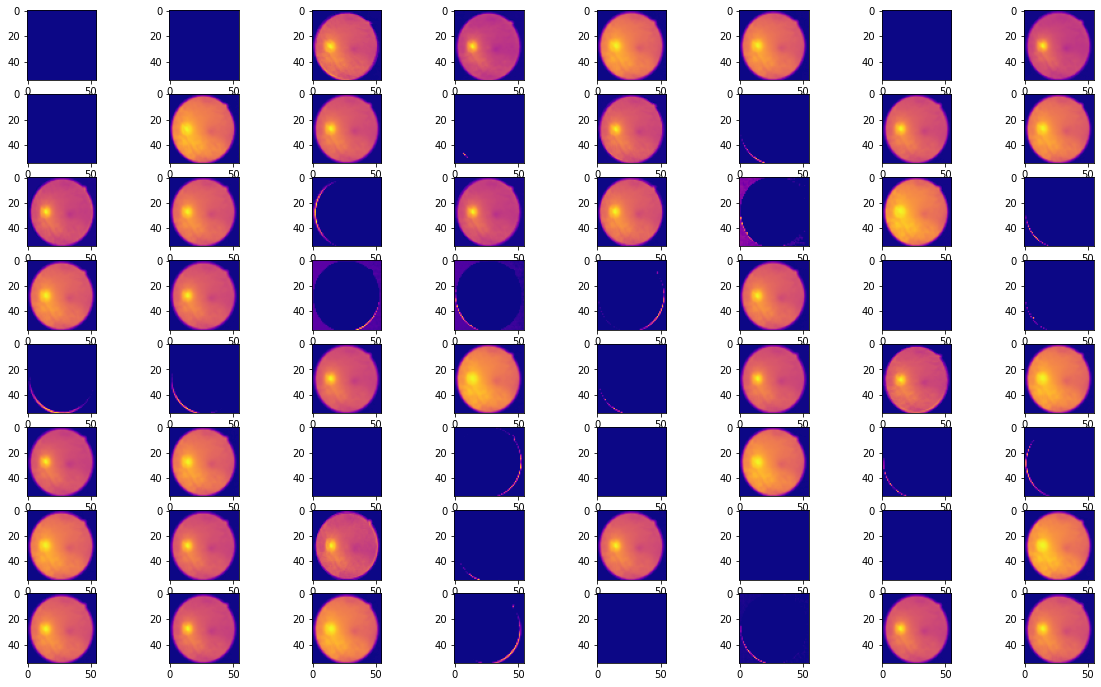

In [27]:
display_activation(activations, 8,8,1)


### Exercise: 
Display the first 64 activations of the 11th model layer (layer index 10) in an 8 x 8 grid

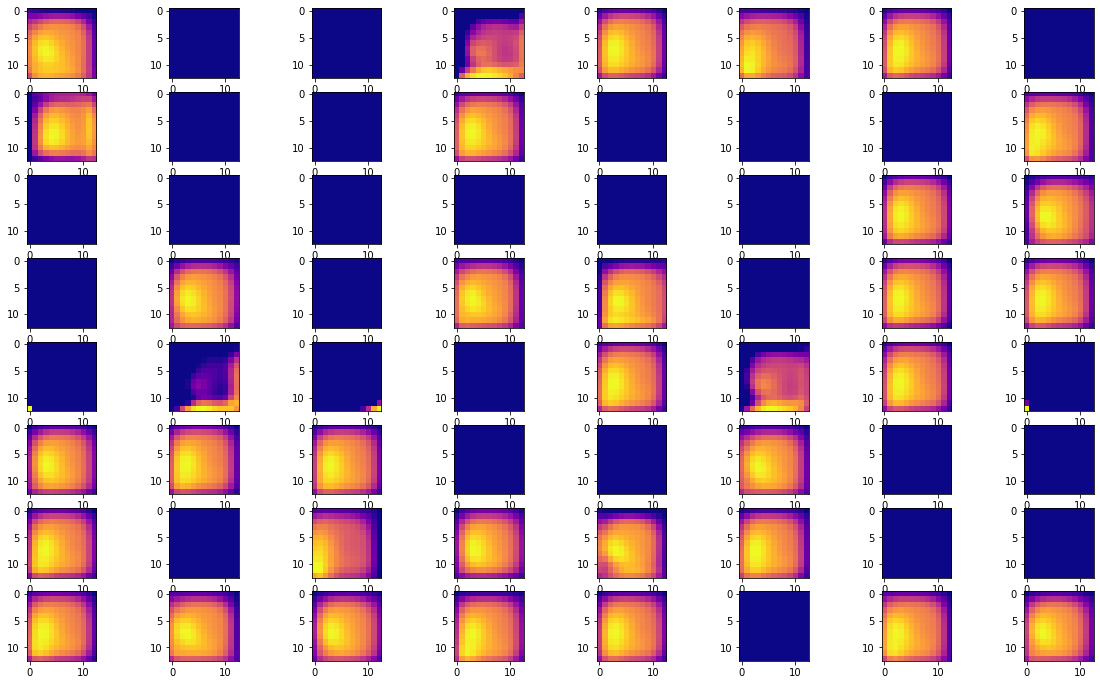

In [28]:
display_activation(activations, 8,8,10)

Comment on the activated feature maps for early layers to later layers. What pattern do you observe?



### Task 3: Regularization by Data Augmentation

We can regularize our model (and, in doing so, hopefully improve it) by augmenting our image data. Image augmentation includes transformations such as rotation, translation, reflection, shearing, and color permutation. TensorFlow provides the ImageDataGenerator class to perform image augmentation in memory; by default, your local storage won't save the newly generated images.

In [29]:
# Create a Data Generator
data_gen_args = dict( 
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.2,
    channel_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    data_format="channels_last",
)
image_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train)
BATCH_SIZE = X_train.shape[0]

Initialize data generator for training/validation and test data sets

In [30]:
train_generator = image_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
test_generator = image_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE)

In [45]:
print(X_train.shape)
print(X_test.shape)

(796, 227, 227, 3)
(398, 227, 227, 3)


Import libraries and set useful parameters

In [31]:
import h5py
seed = 0
aug_batch_size = 6

**Step 1: Understanding the data augmentation process**

Images are randomly generated with the options provided in the image data generator

Epoch 0
(6, 227, 227, 3)


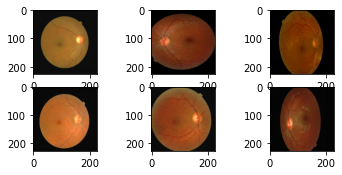

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Epoch 1
(6, 227, 227, 3)


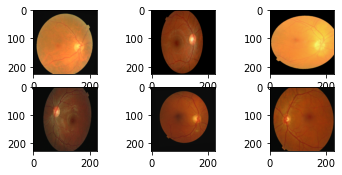

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Epoch 2
(6, 227, 227, 3)


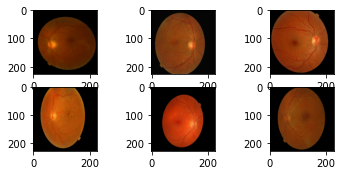

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
Epoch 3
(6, 227, 227, 3)


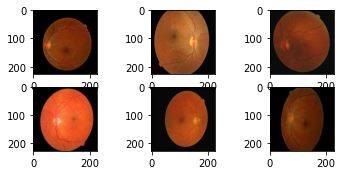

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Epoch 4
(6, 227, 227, 3)


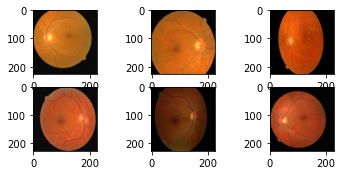

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [32]:
for e in range(5):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in image_datagen.flow(X_train, Y_train, batch_size=aug_batch_size):
        print(x_batch.shape)
        for i in range(0, aug_batch_size):
            plt.subplot(330+1 + i)
            plt.imshow(x_batch[i], cmap=plt.get_cmap('gray'));
        

        plt.show()
        print(y_batch)
        break

**Step 2: Using augmented data to Train the model**

Visualize using tensorboard

**Method 1:**

Iterate through randomized `(X, y)` batches generated by `train_generator` and fit AlexNet to each one

In [33]:
model_reg = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes)

In [48]:
#Method 1: Randomized batches
EPOCHS = 5 #0
reg_history_loss = []
reg_history_vloss = []
reg_history_accuracy = []
reg_history_val_accuracy = []
# Start training
for e in range(EPOCHS):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in train_generator:
        print(x_batch.shape)
        reg_hist = (model_reg.fit(x_batch, y_batch,validation_split=0.2, verbose=1))
        batches += 1
        reg_history_loss.append(reg_hist.history['loss'])
        reg_history_vloss.append(reg_hist.history['val_loss'])
        reg_history_accuracy.append(reg_hist.history['accuracy'])
        reg_history_val_accuracy.append(reg_hist.history['val_accuracy'])
        if batches >= len(X_train) / BATCH_SIZE:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break  




Epoch 0
(796, 227, 227, 3)
20/20 [==============================] - 1s 31ms/step - loss: 0.6935 - accuracy: 0.6038 - val_loss: 1558642.6250 - val_accuracy: 0.4563
Epoch 1
(796, 227, 227, 3)
20/20 [==============================] - 1s 31ms/step - loss: 0.6648 - accuracy: 0.6305 - val_loss: 5650666.5000 - val_accuracy: 0.4187
Epoch 2
(796, 227, 227, 3)
20/20 [==============================] - 1s 31ms/step - loss: 0.6481 - accuracy: 0.6305 - val_loss: 1212883.6250 - val_accuracy: 0.4750
Epoch 3
(796, 227, 227, 3)
20/20 [==============================] - 1s 31ms/step - loss: 0.7225 - accuracy: 0.6038 - val_loss: 87168512.0000 - val_accuracy: 0.5000
Epoch 4
(796, 227, 227, 3)
20/20 [==============================] - 1s 31ms/step - loss: 0.6836 - accuracy: 0.6211 - val_loss: 1272245.2500 - val_accuracy: 0.4875


Plot the losses and accuracies for both training and validation data

In [35]:
#Print the loss and accuracies
#print_loss_history(reg_history)
t_loss = np.squeeze(np.array(reg_history_loss))
v_loss = np.squeeze(np.array(reg_history_vloss))
t_acc  = np.squeeze(np.array(reg_history_accuracy))
v_acc  = np.squeeze(np.array(reg_history_val_accuracy))
print(len(t_loss))

50


Loss

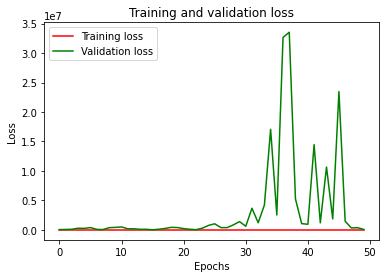

In [36]:
epochs = range(len(t_loss))
plt.plot(epochs, t_loss, color='red', label='Training loss')
plt.plot(epochs, v_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy

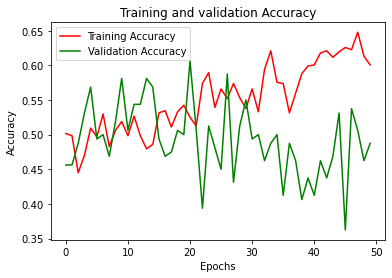

In [37]:
epochs=range(len(t_acc))
plt.plot(epochs, t_acc, color='red', label='Training Accuracy')
plt.plot(epochs, v_acc, color='green', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Method 2:** 

Pass `train_generator` into the model's `fit()` method directly and abstract away the looping

In [54]:
reg_batch_size = 32

In [55]:
train_generator_reg2 = image_datagen.flow(X_train, Y_train, batch_size=reg_batch_size)

In [56]:
#Method 2
model_reg_2 = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), num_classes)
reg_history = model_reg_2.fit(
    train_generator_reg2,
    steps_per_epoch = X_train.shape[0] // reg_batch_size,
    verbose=1, 
    epochs=40,
#    callbacks=[tensorboard_callback]
)

print("Average test loss: ", np.average(reg_history.history['loss']))

Epoch 1/40
24/24 [==============================] - 5s 198ms/step - loss: 13.4841 - accuracy: 0.4961
Epoch 2/40
24/24 [==============================] - 5s 200ms/step - loss: 10.8213 - accuracy: 0.4816
Epoch 3/40
24/24 [==============================] - 5s 194ms/step - loss: 7.7357 - accuracy: 0.5312
Epoch 4/40
24/24 [==============================] - 5s 195ms/step - loss: 4.1533 - accuracy: 0.5217
Epoch 5/40
24/24 [==============================] - 5s 200ms/step - loss: 3.7377 - accuracy: 0.5107
Epoch 6/40
24/24 [==============================] - 5s 201ms/step - loss: 3.7467 - accuracy: 0.5179
Epoch 7/40
24/24 [==============================] - 5s 202ms/step - loss: 2.2397 - accuracy: 0.4816
Epoch 8/40
24/24 [==============================] - 5s 200ms/step - loss: 2.0341 - accuracy: 0.5628
Epoch 9/40
24/24 [==============================] - 5s 203ms/step - loss: 2.2268 - accuracy: 0.5425
Epoch 10/40
24/24 [==============================] - 5s 201ms/step - loss: 1.5558 - accuracy: 0.51

In [57]:
# save the whole model
model_reg_2_dir = "data/reg_model.h5"
model_reg_2.save(model_reg_2_dir)

In [ ]:
%tensorboard --logdir logs/scalars

### Task 4: Evaluate the Regularized Model and Report Results

### Exercise: 

Compute the evaluation metrics

In [59]:
# Import the necessary functions from sklearn.metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
print(f'Accuracy = {accuracy_score(Y_test[:,1], prediction_values)}')
print(f'F1 = {f1_score(Y_test[:,1], prediction_values)}')
print(f'Precision = {precision_score(Y_test[:,1], prediction_values)}')
print(f'Recall = {recall_score(Y_test[:,1], prediction_values)}')
# Display the confusion matrix
print('Confusion matrix =')
confusion_matrix(Y_test[:,1], prediction_values)

Accuracy = 0.5728643216080402
F1 = 0.7222222222222223
Precision = 0.5972972972972973
Recall = 0.9132231404958677
Confusion matrix =


array([[  7, 149],
       [ 21, 221]])

In [41]:
prediction_reg = np.argmax(model_reg.predict(X_test), axis=-1)
print(f'Accuracy = {accuracy_score(Y_test[:,1], prediction_reg)}')
print(f'F1 = {f1_score(Y_test[:,1], prediction_reg)}')
print(f'Precision = {precision_score(Y_test[:,1], prediction_reg)}')
print(f'Recall = {recall_score(Y_test[:,1], prediction_reg)}')
# Display the confusion matrix
print('Confusion matrix =')
confusion_matrix(Y_test[:,1], prediction_reg)

Accuracy = 0.4120603015075377
F1 = 0.21476510067114093
Precision = 0.5714285714285714
Recall = 0.1322314049586777
Confusion matrix =


array([[132,  24],
       [210,  32]])

In [58]:
prediction_reg2 = np.argmax(model_reg_2.predict(X_test), axis=-1)
print(f'Accuracy = {accuracy_score(Y_test[:,1], prediction_reg2)}')
print(f'F1 = {f1_score(Y_test[:,1], prediction_reg2)}')
print(f'Precision = {precision_score(Y_test[:,1], prediction_reg2)}')
print(f'Recall = {recall_score(Y_test[:,1], prediction_reg2)}')
# Display the confusion matrix
print('Confusion matrix =')
confusion_matrix(Y_test[:,1], prediction_reg2)

Accuracy = 0.38944723618090454
F1 = 0.039525691699604744
Precision = 0.45454545454545453
Recall = 0.02066115702479339
Confusion matrix =


array([[150,   6],
       [237,   5]])

# Visualize activations from early layers after regularization and report results

In [42]:
# Use a list comprehension to extract the output of each layer in the model
layer_outputs_reg = [layer.output for layer in model_reg.layers]
# Define a new model with the same input shape as the original model 
# and layer_outputs as its outputs
activation_model_reg = Model(inputs=model_reg.input, outputs=layer_outputs_reg)
# Get all the activations by calling the predict() method on the number 10 image 
# in X_train. Make sure to reshape the image so it has a new 0 axis of length 1.
##activations = activation_model.predict(X_train[0].reshape(1, 227, 227,1)) # activation_model.predict(X_train[0].reshape(1, 227, 227,1))
activations_reg = activation_model_reg.predict(X_train[0][np.newaxis,:])


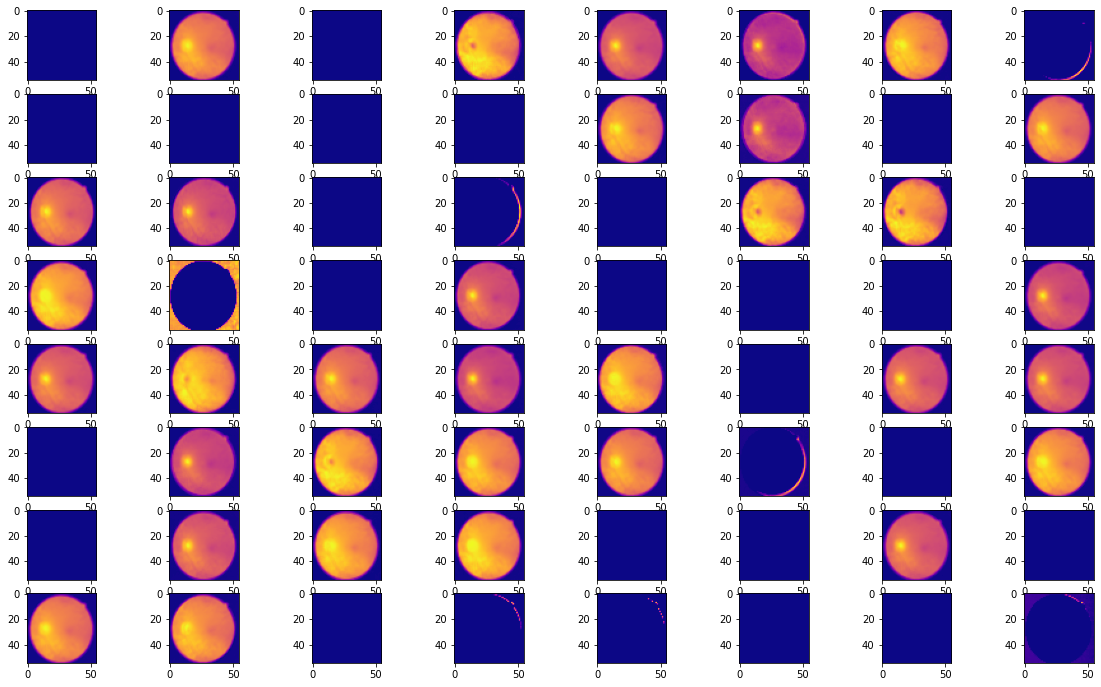

In [43]:
display_activation(activations_reg, 8,8,1)

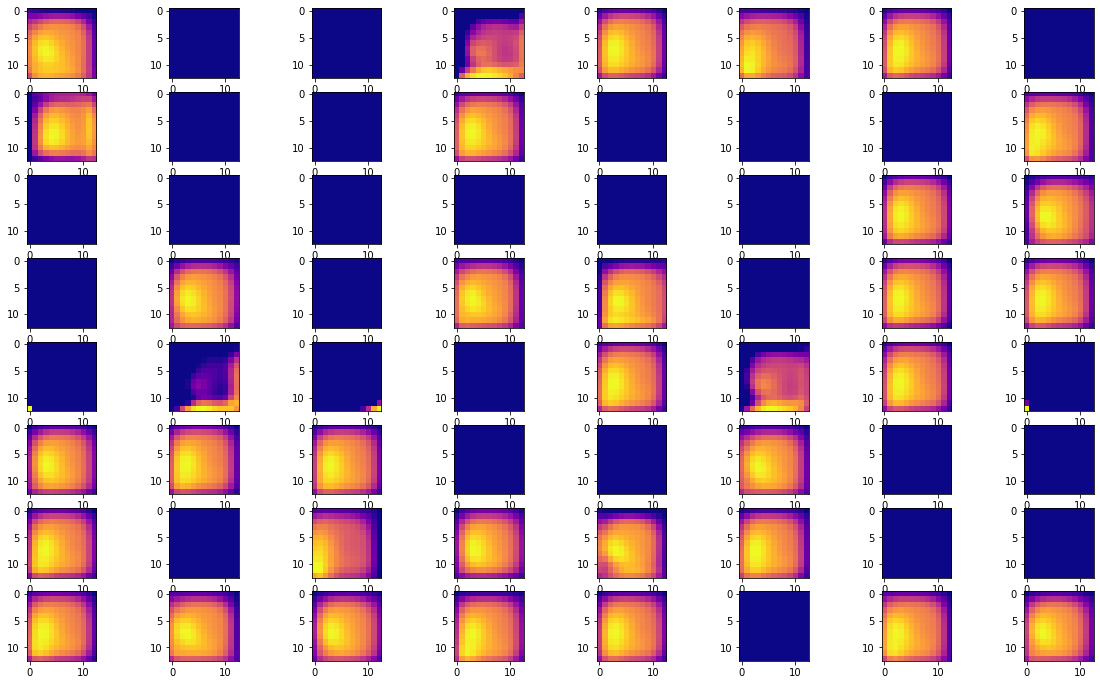

In [44]:
display_activation(activations, 8,8,10)

## Discussion

The primary objective of the project is to provide automatic screening of potential Diabetic Retinopathy patients. As a result, we choose to optimize for the recall metric. Here, we a motivated by identifying the largest class of potential patients even at the cost of high false positives. Given this constraint, we report out the un-regularized model. Based on the performance metrics, adding regularization decreased the accuracy of the model without adding to generalization.   